#LSTM AND BI-LSTM for Temperature Prediction

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,TimeDistributed
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from google.colab import files
# mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['axes.grid'] = True

**Data Importation and Information**

In [ ]:
df = pd.read_csv(r'/content/Daily Abidjan_data.csv')
print(df.info())
df.describe()
df.head(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2557 non-null   object 
 1   T2M     2557 non-null   float64
 2   WS2M    2557 non-null   float64
 3   QV2M    2557 non-null   float64
 4   RH2M    2557 non-null   float64
 5   PREC    2557 non-null   float64
 6   PS      2557 non-null   float64
 7   SWRD    2557 non-null   float64
dtypes: float64(7), object(1)
memory usage: 159.9+ KB
None


,Date,T2M,WS2M,QV2M,RH2M,PREC,PS,SWRD
0,01/01/15,26.56,1.40,10.74,52.75,0.01,100.63,5.15
1,02/01/15,26.72,1.86,9.34,44.62,0.00,100.58,5.58
2,03/01/15,26.72,1.80,14.59,69.06,0.01,100.70,5.73
3,04/01/15,27.51,1.45,16.30,73.00,0.25,100.74,5.39


**Variable ploting**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d0b1c4cd0>,
      dtype=object)

<Figure size 720x576 with 0 Axes>

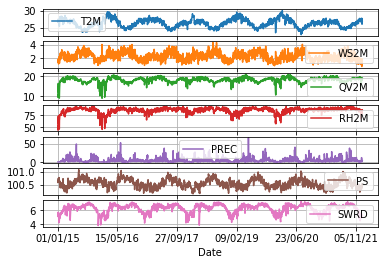

In [ ]:
df.index = pd.to_datetime(df['Date'],infer_datetime_format=True )
plt.figure(figsize=(20,9))
df.set_index('Date')[['T2M', 'WS2M', 'QV2M', 'RH2M', 'PREC', 'PS',
       'SWRD']].plot(subplots=True)


In [ ]:

#################### Datapreprocessing For Temperature   #####################

# Scalling
df_input= df[['T2M', 'WS2M', 'QV2M', 'RH2M', 'PREC', 'PS','SWRD']].sort_index()
scaler=MinMaxScaler()
data_scaled=scaler.fit_transform(df_input)



# define X and Y
features=data_scaled
target=data_scaled[:,0]
# Time series data generation


 # Splitting the dataset into training set and test set
 
X_train,  y_train = features[:1636,:], target[:1636]
X_val,y_val= features[1636:2045,:], target[1636:2045]
X_test,y_test= features[2045:,:], target[2045:]

# Data Transformation 

window_length= 14
b_size= 124
features_num=7
train_generator= TimeseriesGenerator(X_train,y_train,length=window_length,sampling_rate=1,batch_size=b_size)
val_generator= TimeseriesGenerator(X_val,y_val,length=window_length,sampling_rate=1,batch_size=b_size)
test_generator= TimeseriesGenerator(X_test,y_test,length=window_length,sampling_rate=1,batch_size=b_size)

#  LSTM

In [ ]:
########################################################################################################################
#####################################   LSTM MOdel for    Temperature prediction       #################################
########################################################################################################################



model=Sequential()
model.add(LSTM(94, activation='relu', input_shape=(window_length, features_num), return_sequences=False))
# model.add(LSTM(24, activation='relu', return_sequences=True))
# model.add(LSTM(12, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

# Early stopping: Model stops if the validation loss does not improve after 3 more iteration the algorithm stop
early_stopping= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),optimizer='adam',metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])
history=model.fit(train_generator,epochs=160,shuffle=False, validation_data=val_generator,callbacks=[early_stopping])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 94)                38352     
                                                                 
 dropout_2 (Dropout)         (None, 94)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 95        
                                                                 
Total params: 38,447
Trainable params: 38,447
Non-trainable params: 0
_________________________________________________________________
Epoch 1/160
14/14 [==============================] - 2s 49ms/step - loss: 0.0934 - mean_absolute_error: 0.2446 - root_mean_squared_error: 0.3056 - val_loss: 0.0565 - val_mean_absolute_error: 0.2001 - val_root_mean_squared_error: 0.2377
Epoch 2/160
14/14 [==============================] - 0s 30ms/step - loss: 0.04

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

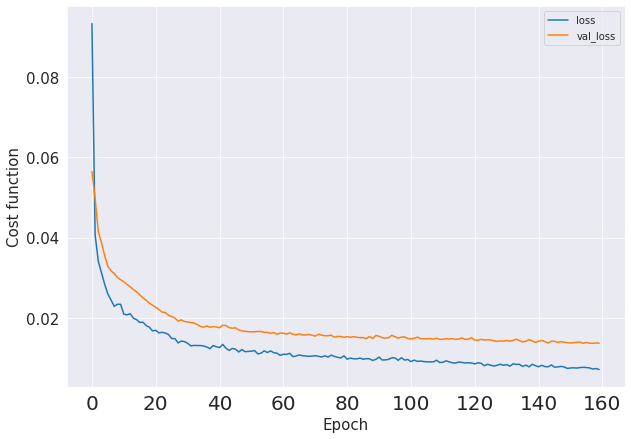

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

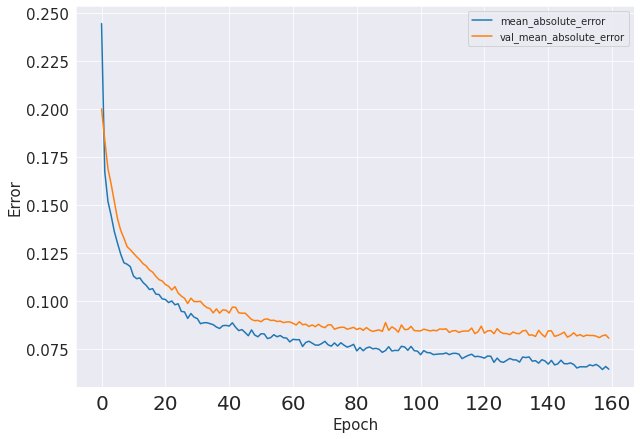

In [ ]:
# Learning Curve


pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(10,7))

plt.ylabel("Cost function",fontsize=15)
plt.xlabel("Epoch",fontsize=15)
plt.savefig('LSTM_TMP_LOSS.png')
files.download("LSTM_TMP_LOSS.png")
plt.show()
pd.DataFrame(history.history)[['mean_absolute_error','val_mean_absolute_error']].plot(figsize=(10,7))
plt.ylabel("Error",fontsize=15)
plt.xlabel("Epoch",fontsize=15)
plt.savefig('LSTM_TMP_ERROR.png')
files.download("LSTM_TMP_ERROR.png")
plt.show()

In [ ]:
# Evaluation pof MSE with the test_generator
model.evaluate(test_generator,verbose=0)

# Predictions
predictions=model.predict(test_generator)

# Consider the values of X_test by ignoring the first 14th
New_X_test=X_test[:,1:][window_length:]

# Datapredicted
df_pred=pd.concat([pd.DataFrame(predictions),pd.DataFrame(New_X_test)],axis=1)
# return the inverse transform of the MinMaxscaler created above to give the real value that we had initially
rev_trans=scaler.inverse_transform(df_pred.values)

# Extraction of the LSTM  prediction and the real value of T2M
df_final=df_input[-predictions.shape[0]:]
df1=df_final['T2M']
rev2=rev_trans[:,0]

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error

# Performance metrics

mse = mean_squared_error(df1, rev2)
r2 = r2_score(df1, rev2)
mae = mean_absolute_error(df1, rev2)
# mae_scaled = mean_absolute_error(X_test[-rev2.shape[0]:,0], predictions[:,0])
mape = mean_absolute_percentage_error(df1, rev2)
print("mse=",mse,3)
print("r2=",r2,3)
print("mae=",mae)
# print("mae_scaled=" + str(round(mae_scaled,2)))
print("mape=",mape)


mse= 0.3185790343463813 3
r2= 0.6260260185292592 3
mae= 0.4310269397153073
mape= 0.016482911735765295


In [ ]:
predictions1.shape

(43, 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

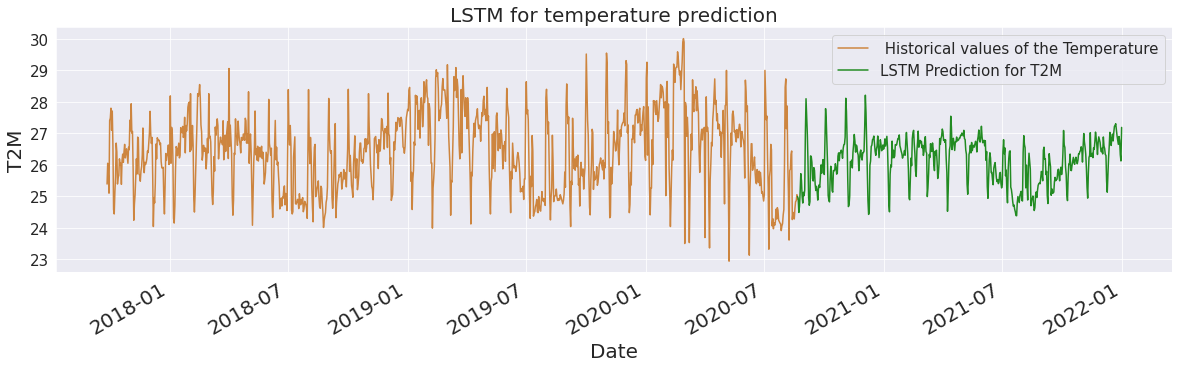

In [ ]:
from google.colab import files

########## Visualization of LSTM Prediction result ##########

dates = pd.date_range('08/21/2020', periods=498)
dates1 = pd.date_range('01/01/2015', periods=2060)
Forecast=pd.DataFrame({  'LSTM Prediction for T2M ':rev2})
Forecast['date']=dates
For=Forecast.set_index('date')
T=df_input['T2M']
D=T[0:2060].to_frame(' Historical values of the Temperature')
D['Date']=dates1
DD=D.set_index('Date')

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20


sns.set_style("darkgrid")
train_forecast = pd.concat([DD,For])
train_forecast[1000:2600].plot.line(figsize=(20, 5), color=['peru','forestgreen'])

plt.ylabel("T2M",fontsize=20)
plt.xlabel("Date",fontsize=20)

plt.title("LSTM for temperature prediction")
plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PRED.png')
files.download("LSTM_TMP_PRED.png")
plt.show()



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

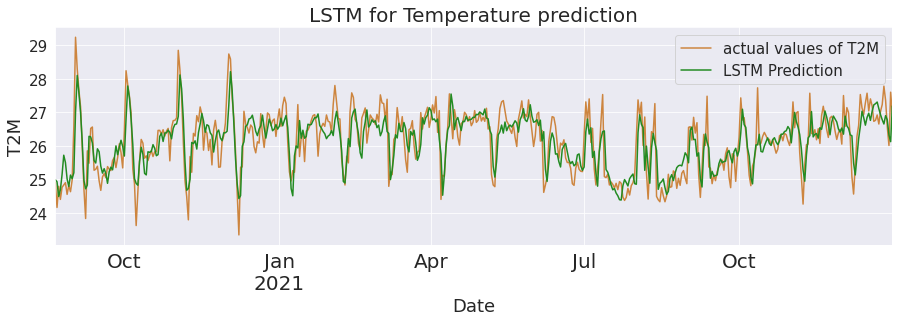

In [ ]:
import matplotlib.dates as mdates
Forecast=pd.DataFrame({'actual values of T2M':df1,'LSTM Prediction ':rev2})
Forecast['date']=dates
For=Forecast.set_index('date')
# For.plot.line(figsize=(17, 4))
train_forecast = pd.concat([DD,For])
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

# train_forecast[2000:2600].plot.line(figsize=(15, 7))
sns.set_style("darkgrid")

For.plot.line(figsize=(15, 4),color=['peru','forestgreen'])
plt.ylabel("T2M",fontsize=18)
plt.xlabel("Date",fontsize=18)
# dates.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# dates.xaxis.set_major_locator(mdates.DayLocator(interval=100))
# dates.tick_params(axis='x', labelrotation=45)
# train_forecast.plot.line(figsize=(35, 7))
plt.title("LSTM for Temperature prediction")
plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PRED_VS.png')
files.download("LSTM_TMP_PREDx.png")
plt.show()



In [ ]:
# plt.scatter(rev2p, df1p,s=10,linewidths=True)
# plt.ylabel(" True Precipitation values")
# plt.xlabel("Predicted Precipitation values")
# plt.title("Scatter plot")
# Concatenated predicted and real values

# BIDIRECTIONAL LSTM

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt

from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from tensorflow.keras import layers

window_length= 14
b_size= 64
features_num=7
train_generatorp= TimeseriesGenerator(X_train,y_train,length=window_length,sampling_rate=1,batch_size=b_size)
val_generatorp= TimeseriesGenerator(X_val,y_val,length=window_length,sampling_rate=1,batch_size=b_size)
test_generatorp= TimeseriesGenerator(X_test,y_test,length=window_length,sampling_rate=1,batch_size=b_size)


In [ ]:
########################################################################################################################
#####################################    Bi-LSTM model for   Temperature prediction       ##############################
########################################################################################################################




model2= keras.Sequential()

model2.add(
    layers.Bidirectional(layers.LSTM(128, return_sequences=False), input_shape=(window_length, features_num))
)
model2.add(layers.Dense(1))
model2.summary()
# Early stopping: Model stops if the validation loss does not improve after 50 more iteration the algorithm stop
early_stopping1= tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50,mode='min')
model2.compile(loss=tf.losses.MeanSquaredError(),optimizer='adam',metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.RootMeanSquaredError()])
history2=model2.fit(train_generatorp,epochs=150,shuffle=False, validation_data=val_generator,callbacks=[early_stopping1])


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 256)              139264    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 139,521
Trainable params: 139,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
26/26 [==============================] - 7s 101ms/step - loss: 0.0539 - mean_absolute_error: 0.1763 - root_mean_squared_error: 0.2321 - val_loss: 0.0369 - val_mean_absolute_error: 0.1561 - val_root_mean_squared_error: 0.1922
Epoch 2/150
26/26 [==============================] - 1s 47ms/step - loss: 0.0243 - mean_absolute_error: 0.1222 - root_mean_squared_error: 0.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

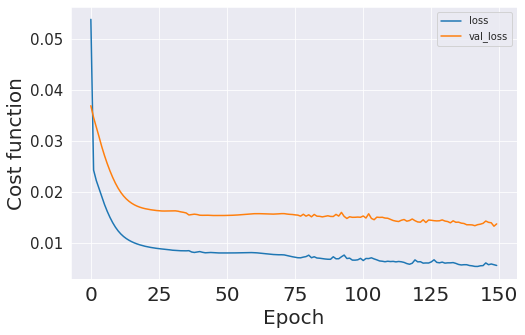

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

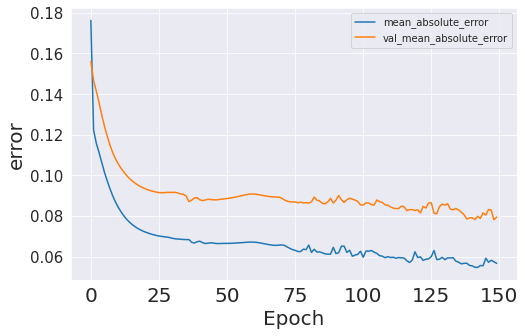

In [ ]:
##### Learning Curve #####

pd.DataFrame(history2.history)[['loss','val_loss']].plot(figsize=(8,5))
plt.ylabel("Cost function")
plt.xlabel("Epoch")
plt.savefig('Bi-LSTM_TMP_LOSS.png')
files.download("Bi-LSTM_TMP_LOSS.png")
plt.show()
pd.DataFrame(history2.history)[['mean_absolute_error','val_mean_absolute_error']].plot(figsize=(8,5))
plt.ylabel("error")
plt.xlabel("Epoch")
plt.savefig('Bi-LSTM_TMP_ERROR.png')
files.download("Bi-LSTM_TMP_ERROR.png")
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

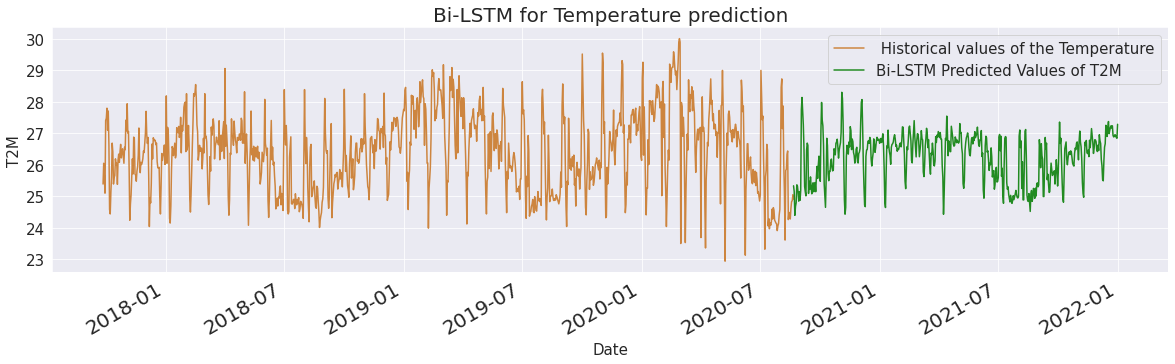

In [ ]:
# Predictions
prediction21=model2.predict_generator(test_generator)

# Consider the values of X_test by ignoring the first 14th
New_X_test2=X_test[:,1:][window_length:]

# Datapredicted
df_pred12=pd.concat([pd.DataFrame(prediction21),pd.DataFrame(New_X_test2)],axis=1)
# return the inverse transform of the MinMaxscaler created above to give the real value that we had initially
rev_trans12=scaler.inverse_transform(df_pred12)
# rev_trans1


# Extraction of T2M prediction and real values

df_final12=df_input[-prediction21.shape[0]:]
df011=df_final12['T2M']
rev022=rev_trans12[:,0]


#####  Forecast visualization  #####



Forecastb=pd.DataFrame({'Bi-LSTM Predicted Values of T2M':rev022})
Forecastb['date']=dates
Forb=Forecastb.set_index('date')
T=df_input['T2M']
D=T[0:2060].to_frame(' Historical values of the Temperature')
D['Date']=dates1
DD=D.set_index('Date')
# figsize=(35, 7)

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

# train_forecast[2000:2600].plot.line(figsize=(15, 7))
sns.set_style("darkgrid")
train_forecast = pd.concat([DD,Forb])
train_forecast[1000:2600].plot.line(figsize=(20, 5), color=['peru','forestgreen'])
plt.ylabel("T2M",fontsize=15)
plt.xlabel("Date",fontsize=15)
plt.title('Bi-LSTM for Temperature prediction')
# train_forecast.plot.line(figsize=(35, 7))
plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PRED.png')
files.download("LSTM_TMP_PRED.png")
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

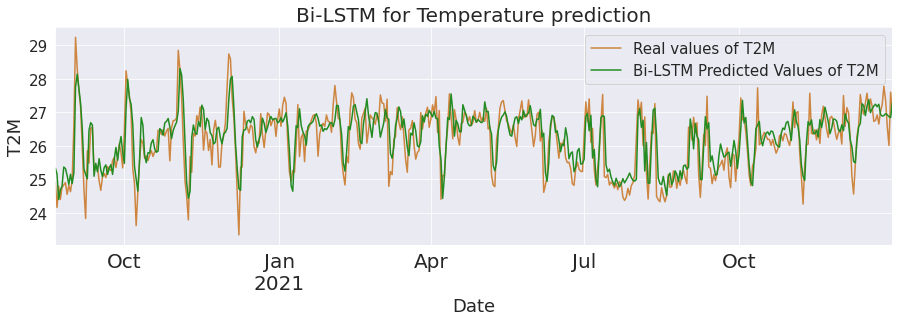

In [ ]:
##### Comparison plot #####

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

sns.set_style("darkgrid")
Forecastb1=pd.DataFrame({'Real values of T2M':df011, 'Bi-LSTM Predicted Values of T2M':rev022})
Forecastb1['date']=dates
Forb1=Forecastb1.set_index('date')
Forb1.plot.line(figsize=(15, 4),color=['peru','forestgreen'])
plt.ylabel("T2M",fontsize=18)
plt.xlabel("Date",fontsize=18)
plt.title('Bi-LSTM for Temperature prediction')
plt.legend(fontsize=15)
plt.savefig('LSTM_TMP_PREDx.png')
files.download("LSTM_TMP_PREDx.png")
plt.show()



In [ ]:
# Performance metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score,mean_absolute_percentage_error
mse1 = mean_squared_error(df011, rev022)
r2_1 = r2_score(df011, rev022)
mae1 = mean_absolute_error(df011, rev022)
# mae1_scaled1 = mean_absolute_error(X_test[-df_pred.shape[0]:,0], prediction[:,0])
mape1 = mean_absolute_percentage_error(df011, rev022)
print("mse=" + str(round(mse1,3)))
print("r2=" + str(round(r2_1,3)))
print("mae=" + str(round(mae1,3)))
# print("mae_scaled=" + str(round(mae1_scaled1,2)))
print("mape=" + str(round(mape1,3)))


mse=0.313
r2=0.633
mae=0.43
mape=0.017
